## https://jakevdp.github.io/blog/2015/07/06/model-complexity-myth/

In [31]:

# Code to create figures
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

def plot_simple_line():
    rng = np.random.RandomState(42)
    x = 10 * rng.rand(20)
    y = 2 * x + 5 + rng.randn(20)
    p = np.polyfit(x, y, 1)
    xfit = np.linspace(0, 10)
    yfit = np.polyval(p, xfit)
    plt.plot(x, y, 'ok')
    plt.plot(xfit, yfit, color='gray')
    plt.text(9.8, 1,
             "y = {0:.2f}x + {1:.2f}".format(*p),
             ha='right', size=14);
    
def plot_underdetermined_fits(p, brange=(-0.5, 1.5), xlim=(-3, 3),
                              plot_conditioned=False):
    rng = np.random.RandomState(42)
    x, y = rng.rand(2, p).round(2)
    xfit = np.linspace(xlim[0], xlim[1])
    for r in rng.rand(20):
        # add a datapoint to make model specified
        b = brange[0] + r * (brange[1] - brange[0])
        xx = np.concatenate([x, [0]])
        yy = np.concatenate([y, [b]])
        theta = np.polyfit(xx, yy, p)
        yfit = np.polyval(theta, xfit)
        plt.plot(xfit, yfit, color='#BBBBBB')
    plt.plot(x, y, 'ok')
    
    if plot_conditioned:
        X = x[:, None] ** np.arange(p + 1)
        theta = np.linalg.solve(np.dot(X.T, X)
                                + 1E-3 * np.eye(X.shape[1]),
                                np.dot(X.T, y))
        Xfit = xfit[:, None] ** np.arange(p + 1)
        yfit = np.dot(Xfit, theta)
        plt.plot(xfit, yfit, color='black', lw=2)

def plot_underdetermined_line():
    plot_underdetermined_fits(1)
        
def plot_underdetermined_cubic():
    plot_underdetermined_fits(3, brange=(-1, 2),
                            xlim=(0, 1.2))
    
def plot_conditioned_line():
    plot_underdetermined_fits(1, plot_conditioned=True)

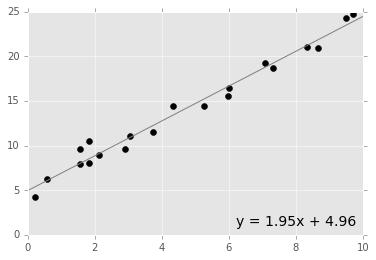

In [32]:
plot_simple_line()

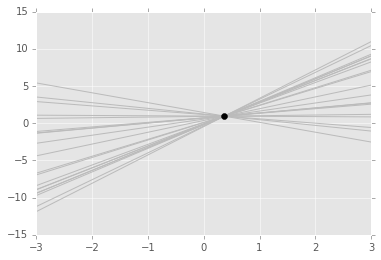

In [33]:

plot_underdetermined_line()


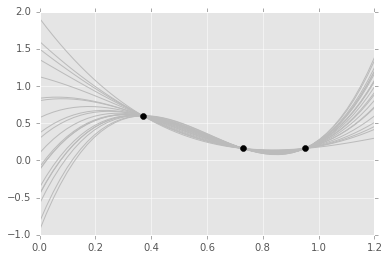

In [34]:
plot_underdetermined_cubic()


In [35]:
X = np.array([[1, 0.37]])

In [36]:
C = np.dot(X.T, X)

In [37]:

np.linalg.inv(C)

array([[ -4.89319674e+16,   1.32248560e+17],
       [  1.32248560e+17,  -3.57428542e+17]])

In [38]:
cond = 1E-3 * np.eye(2)
np.linalg.inv(C + cond)

array([[ 121.18815362, -325.16038316],
       [-325.16038316,  879.69065823]])

In [40]:
b, m = np.linalg.solve(C + cond,
                       np.dot(X.T, [0.95]))
print("Conditioned best-fit model:")
print("y = {0:.3f} x + {1:.3f}".format(m, b))

Conditioned best-fit model:
y = 0.309 x + 0.835


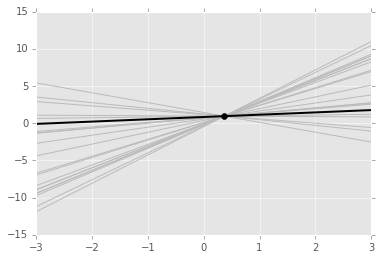

In [41]:

plot_conditioned_line()


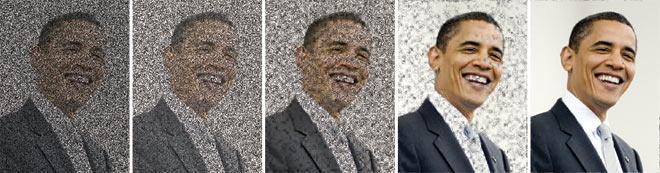

In [43]:
from IPython.display import Image
Image('http://www.wired.com/magazine/wp-content/images/18-03/ff_algorithm2_f.jpg')

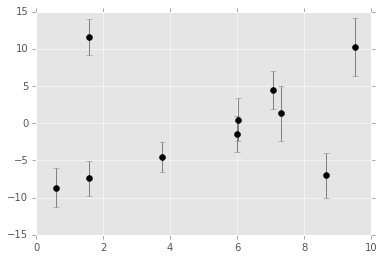

In [44]:
rng = np.random.RandomState(42)
theta = [-10, 2]
x = 10 * rng.rand(10)
dy = 2 + 2 * rng.rand(10)
y = theta[0] + theta[1] * x + dy * rng.randn(10)
y[4] += 15
y[7] -= 10
plt.errorbar(x, y, dy, fmt='ok', ecolor='gray');

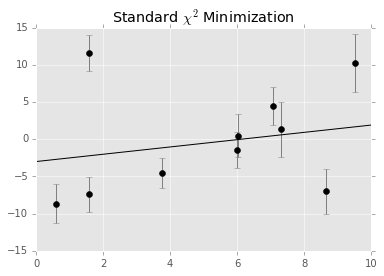

In [45]:
from scipy import optimize

def chi2(theta, x=x, y=y, dy=dy):
    y_model = theta[0] + theta[1] * x
    return np.sum(0.5 * ((y - y_model) / dy) ** 2)

theta1 = optimize.fmin(chi2, [0, 0], disp=False)

xfit = np.linspace(0, 10)
plt.errorbar(x, y, dy, fmt='ok', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Standard $\chi^2$ Minimization');

In [46]:
# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i

def log_prior(theta):
    g = theta[2:]
    #g_i needs to be between 0 and 1
    if (np.any(g < 0) or np.any(g > 1)):
        return -np.inf # recall log(0) = -inf
    else:
        return -g.sum()

def log_likelihood(theta, x, y, dy):
    sigma_y = np.std(y)
    y_model = theta[0] + theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    # log-likelihood for in-lier
    logL_in = -0.5 * (np.log(2 * np.pi * dy ** 2) + ((y - y_model) / dy)** 2)
    # log-likelihood for outlier
    logL_out = -0.5 * (np.log(2 * np.pi * sigma_y ** 2) + ((y - y_model) / sigma_y) ** 2)
    return np.sum(np.logaddexp(np.log(1 - g) + logL_in,
                               np.log(g) + logL_out))

def log_posterior(theta, x, y, dy):
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

In [47]:
import emcee

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set walkers near the maximum likelihood
# adding some random scatter
rng = np.random.RandomState(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = rng.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = rng.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, dy])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

ImportError: No module named 'emcee'

In [48]:

plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

NameError: name 'sample' is not defined

In [49]:
theta2 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g > 0.5)

plt.errorbar(x, y, dy, fmt='ok', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='gray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Bayesian Fit');

NameError: name 'sample' is not defined